# Dynamic Community Discovery

In [52]:
import os
import numpy as np

import dynetx as dn
import networkx as nx
from cdlib import algorithms, evaluation, TemporalClustering

import matplotlib.pyplot as plt

In [3]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

## Instant Optimal

In [63]:
principal_component_week_graph = []
for t in range(6):
    week_graph = nx.read_gexf(os.path.join("..","data_collection","graph", f"network_week_{t+1}.gexf"))
    week_graph_undirected = week_graph.to_undirected()
    print(f"Settimana {t+1}:")
    print(f"Number of component: {nx.number_connected_components(week_graph_undirected)}")
    size_principal_component = len(list(nx.connected_components(week_graph_undirected))[0])
    print(f"Principal component: {size_principal_component/week_graph_undirected.number_of_nodes() * 100:.1f}% ({size_principal_component}/{week_graph_undirected.number_of_nodes()})\n")
    principal_component_week_graph.append(nx.subgraph(week_graph_undirected, list(nx.connected_components(week_graph_undirected))[0]))

Settimana 1:
Number of component: 165
Principal component: 92.7% (4565/4924)

Settimana 2:
Number of component: 138
Principal component: 94.4% (5082/5384)

Settimana 3:
Number of component: 137
Principal component: 94.2% (4754/5046)

Settimana 4:
Number of component: 161
Principal component: 95.2% (6968/7319)

Settimana 5:
Number of component: 180
Principal component: 95.4% (8185/8577)

Settimana 6:
Number of component: 208
Principal component: 93.1% (6231/6695)



Come si nota dai risultati sopra la componente principale è dominante. Scelgo di utilizzare solo quella per evitare un eccesso di comminity  dovute alle varie componenti frammentate.

In [64]:
tc = TemporalClustering()
for t in range(6):
    coms = algorithms.louvain(principal_component_week_graph[t]) 
    tc.add_clustering(coms, t)

La cella successiva calcola la similarità tra le community di due settimane consecutive.
**NF1** è la versione normalizzata dell'F1 score, valuta la capacità di un clustering di "predire" un altro clustering.
Non è possibile utilizzare l'**NMI** perché **presuppone che l'insieme di nodi sia fisso**, altrimenti il confronto tra le distribuzioni di comunità non ha senso (se il numero di nodi è diverso, le distribuzioni di probabilità cambiano e il calcolo dell'NMI non è più ben definito). 
Invece l'**NF1** funziona a livello di comunità, confrontando la sovrapposizione tra insiemi di nodi che appartengono alle stesse comunità nei due snapshot. Se un nodo esiste solo in uno snapshot, semplicemente non partecipa al confronto.

In [65]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.003625772879423501,
 0.0040193354394245035,
 0.007342149376047683,
 0.0035294117647058833,
 0.0028809123649459786]

In [66]:
tc.has_explicit_match()

False

La funzione 'community_matching' non è più valida, bisogna calcolare manualmente il matching tra le community delle differenti snapshots.

In [188]:
# Definizione della metrica di similarità (Jaccard)
def jaccard_similarity(comm1, comm2):
    set1, set2 = set(comm1), set(comm2)
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

# Creazione dei match tra cluster di snapshot consecutivi
matches = []

# Itera tra snapshot consecutivi
for t in range(5):  # Confronta t con t+1
    c_t = tc.clusterings[t]  # Comunità al tempo t
    c_t1 = tc.clusterings[t + 1]  # Comunità al tempo t+1

    best_matches = {}  # Dizionario per salvare il miglior match per ogni comunità di t

    # Itera tra tutte le coppie di comunità tra t e t+1
    for i, com1 in enumerate(c_t.communities):
        best_jaccard = 0
        best_match = None

        for j, com2 in enumerate(c_t1.communities):
            score = jaccard_similarity(com1, com2)

            if score > best_jaccard:  # Aggiorna il miglior match per questa comunità
                best_jaccard = score
                best_match = (f"{t}_{i}", f"{t+1}_{j}", score)

        if best_match:  # Aggiunge solo il miglior match trovato
            matches.append(best_match)

# Aggiunge il matching precomputato a TemporalClustering
tc.add_matching(matches)


In [189]:
# I risultati sono del tipo ('community snapshot t', 'community snapshot t+1', 'jaccard score')
matches[0]

('0_0', '1_0', 0.17925591882750846)

In [190]:
# Verifica
c1 = tc.get_clustering_at(0).named_communities[matches[0][0]]
c2 = tc.get_clustering_at(1).named_communities[matches[0][1]]
jaccard_similarity(c1, c2)

0.17925591882750846

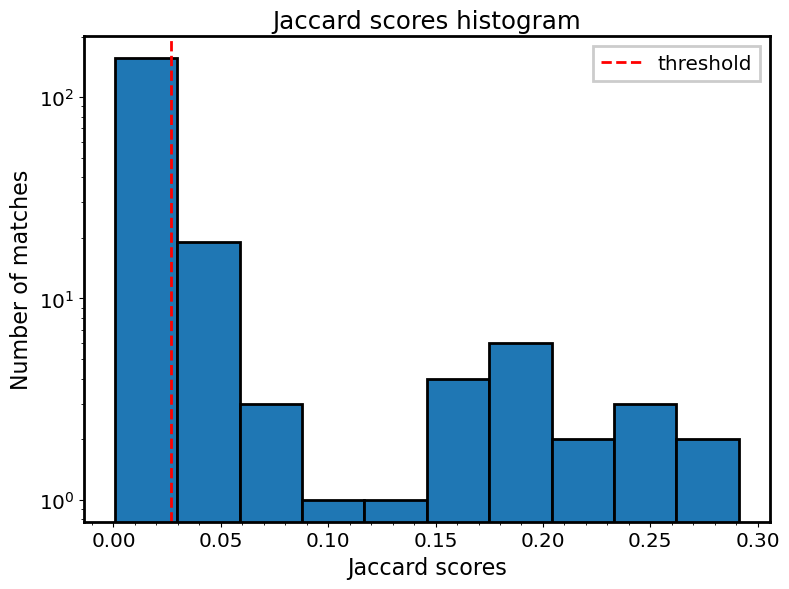

In [191]:
# Istogramma dei valori dei jaccard scores con una threshold sul 75° percentile
jaccard_scores = np.array([t[2] for t in matches])
plt.hist(jaccard_scores, log=True, edgecolor='black')
threshold = np.percentile(jaccard_scores, 75)
plt.axvline(x=threshold, linestyle='--', color='r', label='threshold')
plt.title("Jaccard scores histogram")
plt.xlabel("Jaccard scores")
plt.ylabel("Number of matches")
plt.legend()

In [171]:
jaccard_scores.size

197

In [172]:
jaccard_scores[jaccard_scores >= threshold].size

50

In [192]:
# Seleziono solo i matches con score maggiore al 75° percentile 
matches_array = np.asarray(matches)
matches_array_filtered = matches_array[jaccard_scores >= threshold]
matches_array_filtered.shape

(50, 3)

In [176]:
def community_evolution_graph(matches_array, snapshot_list):
    # Creazione del grafo direzionale
    G = nx.DiGraph()
    # Aggiunta degli archi al grafo
    for row in matches_array:
        nodo_start, nodo_end, peso = row
        G.add_edge(nodo_start, nodo_end, weight=float(peso))
    
    for community in list(G.nodes):
        snapshot_number = int(community.split('_')[0])
        community_nodes = tc.get_clustering_at(snapshot_number).named_communities[community]
        
        # Estrazione e calcolo della media
        opinions = [snapshot_list[snapshot_number].nodes[n]["opinion"] for n in community_nodes]
        mean_opinion = sum(opinions) / len(opinions) if opinions else 0
    
        # Aggiunge l'attributo mean_opinion ai nodi del grafico
        G.nodes[community]["mean_opinion"] = mean_opinion
        
    return G

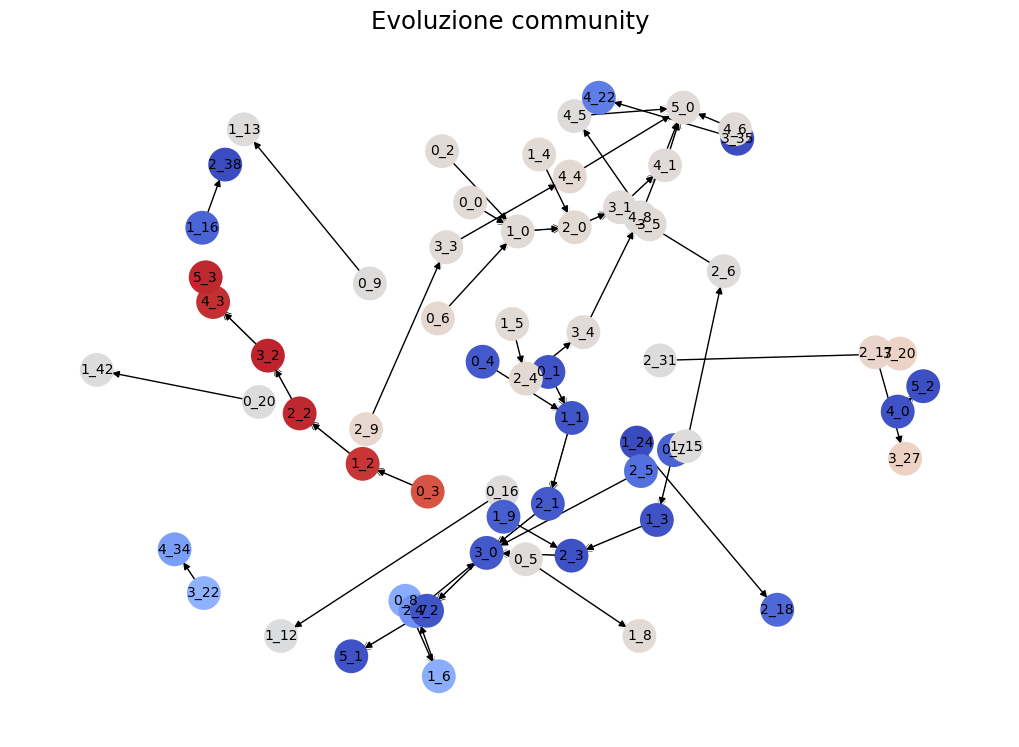

In [177]:
# Per visibilità crea il plot solo nel caso di community filtrate
G = community_evolution_graph(matches_array_filtered, principal_component_week_graph)

# Posizioni dei nodi
pos = nx.spring_layout(G, seed=42)  # Layout per disposizione dei nodi

# Estrai i valori di mean_opinion per colorare i nodi
mean_opinions = np.array([G.nodes[n]["mean_opinion"] for n in G.nodes()])

# Mappa di colori (da blu [0] a rosso [1])
node_colors = plt.cm.coolwarm(mean_opinions)

# Disegna il grafo con colori basati su mean_opinion
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, cmap=plt.cm.coolwarm, 
        font_size=10, edge_color="black")

# Estrai i pesi degli archi
weights = [G[u][v]["weight"] for u, v in G.edges()]

# Disegna gli archi con spessore basato sul peso
nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights], arrowstyle='->', arrowsize=15)

# Mostra il grafico
plt.title("Evoluzione community")
plt.savefig(os.path.join('plots', 'Evoluzione community'))
plt.show()

Nel grafico superiore non è possibile vedere dei cambi di categoria perché sono stati presi solo i collegamenti con maggior jaccard scores. Le transizioni rappresentano community simili tra loro, quindi con una bassa probabilità di cambiare la categoria.

In [182]:
from collections import defaultdict

# Per avere i risultati completi utilizzo tutti i matches
G = community_evolution_graph(matches_array, principal_component_week_graph)

# Definizione delle categorie di opinion
def categorize_opinion(mean_opinion):
    if mean_opinion <= 0.333:
        return "pro-Biden"
    elif mean_opinion >= 0.666:
        return "pro-Trump"
    else:
        return "neutral"

# Creazione del dizionario per memorizzare le categorie per snapshot
snapshot_categories = defaultdict(dict)

# Popoliamo il dizionario con le categorie di ogni nodo in base alla snapshot
for community in G.nodes():
    snapshot_number, community_id = map(int, community.split('_'))
    mean_opinion = G.nodes[community]["mean_opinion"]
    category = categorize_opinion(mean_opinion)
    snapshot_categories[snapshot_number][community] = category

# Dizionario per il conteggio totale di tutte le transizioni
total_transitions = defaultdict(int)

# Conta le transizioni tra snapshot consecutive e le stampa separatamente
for snapshot in range(max(snapshot_categories.keys())):  # Itera su snapshot 0,1,2,3,4
    if snapshot in snapshot_categories and (snapshot + 1) in snapshot_categories:
        current_snapshot = snapshot_categories[snapshot]
        next_snapshot = snapshot_categories[snapshot + 1]

        transition_counts = defaultdict(int)  # Conta solo per questa coppia di snapshot

        for community, category in current_snapshot.items():
            next_community = f"{snapshot + 1}_{community.split('_')[1]}"  # Trova la stessa community nella snapshot successiva
            if next_community in next_snapshot:
                transition = (category, next_snapshot[next_community])
                transition_counts[transition] += 1
                total_transitions[transition] += 1  # Aggiorna il conteggio totale

        # Stampa i risultati per questa transizione
        print(f"\n- Transizioni da Settimana {snapshot + 1} a Settimana {snapshot + 2}:")
        for transition, count in transition_counts.items():
            print(f"  {transition[0]} -> {transition[1]}: {count} volte")

# Stampa il conteggio totale di tutte le transizioni
print("\n- Totale Transizioni su tutte le snapshot:")
for transition, count in total_transitions.items():
    print(f"  {transition[0]} -> {transition[1]}: {count} volte")




- Transizioni da Settimana 1 a Settimana 2:
  neutral -> neutral: 15 volte
  pro-Biden -> pro-Biden: 4 volte
  neutral -> pro-Trump: 2 volte
  pro-Trump -> pro-Biden: 1 volte
  pro-Biden -> neutral: 5 volte
  neutral -> pro-Biden: 7 volte

- Transizioni da Settimana 2 a Settimana 3:
  neutral -> neutral: 17 volte
  pro-Biden -> pro-Biden: 6 volte
  pro-Trump -> pro-Trump: 1 volte
  pro-Biden -> neutral: 6 volte
  neutral -> pro-Biden: 5 volte
  pro-Trump -> neutral: 2 volte
  pro-Trump -> pro-Biden: 1 volte

- Transizioni da Settimana 3 a Settimana 4:
  neutral -> pro-Biden: 2 volte
  pro-Biden -> neutral: 9 volte
  pro-Trump -> pro-Trump: 1 volte
  neutral -> neutral: 21 volte
  pro-Biden -> pro-Biden: 3 volte
  neutral -> pro-Trump: 2 volte
  pro-Trump -> neutral: 1 volte

- Transizioni da Settimana 4 a Settimana 5:
  neutral -> neutral: 21 volte
  pro-Biden -> pro-Biden: 4 volte
  pro-Trump -> pro-Biden: 1 volte
  neutral -> pro-Trump: 1 volte
  pro-Biden -> neutral: 1 volte
  neut

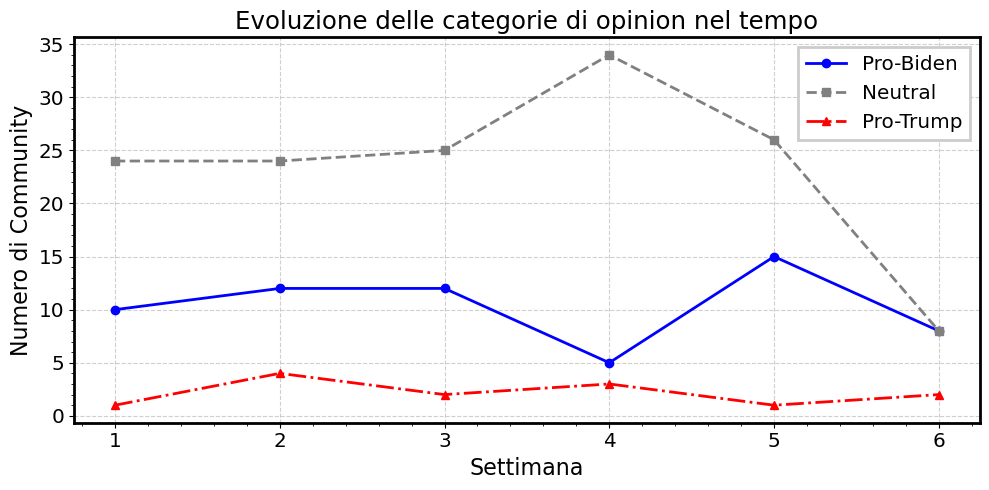

In [194]:
# Conta il numero di community in ogni categoria per ciascuna snapshot
category_counts_per_snapshot = defaultdict(lambda: {"pro-Biden": 0, "neutral": 0, "pro-Trump": 0})

for snapshot, communities in snapshot_categories.items():
    for _, category in communities.items():
        category_counts_per_snapshot[snapshot][category] += 1

# Estrai le snapshot in ordine
snapshots = sorted(category_counts_per_snapshot.keys())

# Estrarre i dati per il plot
pro_biden_counts = [category_counts_per_snapshot[s]["pro-Biden"] for s in snapshots]
neutral_counts = [category_counts_per_snapshot[s]["neutral"] for s in snapshots]
pro_trump_counts = [category_counts_per_snapshot[s]["pro-Trump"] for s in snapshots]

# Modifica i valori delle settimane per partire da 1
snapshot_labels = [s + 1 for s in snapshots]

# Creazione del plot
plt.figure(figsize=(10, 5))
plt.plot(snapshot_labels, pro_biden_counts, marker="o", linestyle="-", label="Pro-Biden", color="blue")
plt.plot(snapshot_labels, neutral_counts, marker="s", linestyle="--", label="Neutral", color="gray")
plt.plot(snapshot_labels, pro_trump_counts, marker="^", linestyle="-.", label="Pro-Trump", color="red")

# Personalizzazione del grafico
plt.xlabel("Settimana")
plt.ylabel("Numero di Community")
plt.title("Evoluzione delle categorie di opinion nel tempo")
plt.xticks(snapshot_labels)  # Ora i tick partono da 1
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()


E' possibile notare un **picco nella quarta settimana** (corrispondente all'**attentato di Trump**). Se assumiamo che i neutrali corripondono ai conservativi. Come si può vedere nell'immagine del grafico su gephi il cluster neutrale è vicino a quello pro-Trump composto dal subreddit r/trump, quindi si può ipotizzare che corrisponde principalmente al subreddit r/conservative. Se è vero, spiegherebbe il grosso picco sui neutrali; si noti ancheun leggero picco per i pro-Trump. Altro punto interessante è il picco per i pro-Biden che si può vedere nella **quinta settimana**, che corrisponde alla **candidatura di Kamala Harris**) 